# Data cleaning

This is a data cleaning performed on the real estate market trends in Conneticut. 


The raw data file was obtained from https://catalog.data.gov/dataset/real-estate-sales-2001-2018. On the wbsite, the file is described to include

>town, property address, date of sale, property type (residential, apartment, commercial, industrial or vacant land), sales price, and property assessment. 

>Annual real estate sales are reported by grand list year (October 1 through September 30 each year). For instance, sales from 2018 GL are from 10/01/2018 through 9/30/2019 (Data.gov).


Frequently used libraries are imported:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
import osmnx as ox
import geopandas as gpd
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.preprocessing import StandardScaler, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import re

In [4]:
real_estate=pd.read_csv('updated_real_estate.csv')
real_estate.reset_index(drop=True)

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_83012/419049329.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate=pd.read_csv('updated_real_estate.csv')


,Unnamed: 0,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Full Address,coordinates,latitude,longitude
0,67070,60228,2006,07/05/2007,Bethel,10 HUNTINGTON COURT,120960.0,250000.0,0.483840,Condo,Condo,NaN,NaN,NaN,NaN,"10, Huntington Court, Bethel",NaN,39.857792,-74.885918
1,67075,60075,2006,04/05/2007,Essex,7 PRATT ST,143400.0,339500.0,0.422386,Condo,Condo,NaN,NaN,NaN,NaN,"7, Pratt St, Essex",NaN,-45.596619,170.671109
2,67080,60416,2006,05/25/2007,Newington,29 STERLING DR,221970.0,340000.0,0.652853,Condo,Condo,NaN,NaN,NaN,NaN,"29, Sterling Dr, Newington",NaN,42.238392,-72.673705
3,67083,60537,2006,08/31/2007,Branford,91 JEFFERSON WOODS,118800.0,210000.0,0.565714,Condo,Condo,NaN,NaN,NaN,NaN,"91, Jefferson Woods, Branford",NaN,14.610608,121.000970
4,67085,60421,2006,05/08/2007,Glastonbury,9 BOXWOOD LN,84000.0,174000.0,0.482759,Condo,Condo,NaN,NaN,NaN,NaN,"9, Boxwood Ln, Glastonbury",NaN,39.487979,-76.645549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105415,997168,1900695,2019,02/24/2020,Stamford,39 WOODWAY ROAD UNIT C6,188410.0,379000.0,0.497124,Condo,Condo,07 - Change in Property,NaN,TOTAL RENOVATION PER MLS - SEE PREVIOUS SALE #...,POINT (-73.51447 41.10279),"39, Woodway Road, Stamford","<re.Match object; span=(6, 26), match='(-73.51...",-73.514470,41.102790
105416,997171,190079,2019,03/06/2020,Prospect,56 TAMARACK CT,8750.0,356021.0,0.024600,Condo,Condo,07 - Change in Property,NaN,NaN,NaN,"56, Tamarack Ct, Prospect",NaN,NaN,NaN
105417,997177,190285,2019,05/18/2020,Wethersfield,89 OXFORD ST,95760.0,130900.0,0.731600,Condo,Condo,NaN,NaN,NaN,NaN,"89, Oxford St, Wethersfield",NaN,NaN,NaN
105418,997191,190095,2019,12/09/2019,Windsor,31 HUDSON LN,176890.0,257500.0,0.687000,Condo,Condo,NaN,NaN,NaN,NaN,"31, Hudson Ln, Windsor",NaN,NaN,NaN


In [5]:
def extract_street_number(address):
    """
    Extracts the street number from the given address using a regular expression.
    
    Args:
        address (str or None): The address string.
        
    Returns:
        str or None: The extracted street number or None if not found.
    """
    if pd.notnull(address):
        address = str(address)
        number_finder = r'^\d+'
        street_number = re.search(number_finder, address)
        if street_number:
            return street_number.group()
    return None

In [9]:

def extract_street_name(address):
    """
    Extracts and processes the street name from an address.

    Args:
        address (str or None): The address string.

    Returns:
        str or None: The extracted street name or None if not found.
    """
    if pd.notnull(address):
        address = str(address)

        # Convert the entire address to lowercase
        address = address.lower()

        # Remove unit numbers from the address
        address_without_units = re.sub(r'\b(?:unit|suite|apt|apartment|#|-)\b\s*[\w\d-]+', '', address)

        # Find the street number
        number_finder = r'^\d+'
        street_number = re.search(number_finder, address_without_units)

        if street_number:
            # Remove the street number from the address
            address_without_number = re.sub(number_finder, '', address_without_units).strip()

            # Capitalize the first letter of each word in the address without the number
            street_name = address_without_number.title()

            # Replace abbreviations with full words
            street_name = re.sub(r'\bst\b', 'street', street_name)

            return street_name
    return None

In [10]:
real_estate["Full Address"] = real_estate["Address"].apply(extract_street_number) + ", " + real_estate["Address"].apply(extract_street_name) + ", " + real_estate["Town"]
real_estate.sample(20)

,Unnamed: 0,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Full Address,coordinates,latitude,longitude
12650,459614,60866,2006,07/17/2007,Stratford,3699 BROADBRIDGE UT 221,71330.0,123000.0,0.579919,Condo,Condo,NaN,NaN,NaN,POINT (-73.16186 41.21892),"3699, Broadbridge Ut 221, Stratford","<re.Match object; span=(6, 26), match='(-73.16...",-73.161860,41.218920
52279,687123,130089,2013,06/23/2014,North Branford,239 TWIN LAKES RD #B,145900.0,128000.0,1.139844,Condo,Condo,14 - Foreclosure,NaN,NaN,NaN,"239, Twin Lakes Rd #B, North Branford",NaN,NaN,NaN
34251,579580,10891,2010,05/02/2011,Bridgeport,17 CANTERYBURY ROAD,95930.0,109000.0,0.880092,Condo,Condo,NaN,NaN,NaN,POINT (-73.22497 41.21238),"17, Canterybury Road, Bridgeport","<re.Match object; span=(6, 26), match='(-73.22...",-73.224970,41.212380
101557,973537,190203,2019,03/10/2020,Southbury,30 B HERITAGE VILLAGE,50880.0,110000.0,0.462500,Condo,Condo,NaN,NaN,NaN,NaN,"30, B Heritage Village, Southbury",NaN,NaN,NaN
52961,691023,130273,2013,06/30/2014,Simsbury,114 LIBRARY LANE,77380.0,105000.0,0.736952,Condo,Condo,NaN,NaN,NaN,NaN,"114, Library Lane, Simsbury",NaN,NaN,NaN
104496,991190,190400002,2019,04/01/2020,Woodbury,30 CLUBHOUSE DRIVE,80220.0,169500.0,0.473300,Condo,Condo,07 - Change in Property,KITCHEN AND BATHROOM RENOS WITHOUT PERMITS - L...,NaN,NaN,"30, Clubhouse Drive, Woodbury",NaN,NaN,NaN
62528,746406,140268,2014,09/09/2015,Old Saybrook,11 COULTER ST UNIT 19,250800.0,330000.0,0.760000,Condo,Condo,NaN,NaN,NaN,NaN,"11, Coulter St, Old Saybrook",NaN,NaN,NaN
7745,434098,61599,2006,05/11/2007,Bridgeport,2625 PARK AVE UT 9J,87541.0,189900.0,0.460985,Condo,Condo,NaN,NaN,NaN,NaN,"2625, Park Ave Ut 9J, Bridgeport",NaN,NaN,NaN
3669,413419,60793,2006,06/04/2007,Bristol,410 EMMETT ST U35,62150.0,169000.0,0.367751,Condo,Condo,NaN,NaN,NaN,NaN,"410, Emmett St U35, Bristol",NaN,54.088992,-8.513037
21144,506670,80435,2008,07/29/2009,Middletown,85 TROLLEY CROSSING,109380.0,176000.0,0.621477,Condo,Condo,NaN,NaN,NaN,NaN,"85, Trolley Crossing, Middletown",NaN,NaN,NaN


In [ ]:
def extract_coordinates(location):
    if isinstance(location, str):
        match = re.search(r'\((-?\d+\.\d+)\s(-?\d+\.\d+)\)', location)
        if match:
            return match
    return None

real_estate['coordinates'] = real_estate['Location'].apply(extract_coordinates)

real_estate


,Unnamed: 0,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,Full Address,coordinates,latitude,longitude
0,67070,60228,2006,07/05/2007,Bethel,10 HUNTINGTON COURT,120960.0,250000.0,0.483840,Condo,Condo,NaN,NaN,NaN,NaN,"10, Huntington Court, Bethel",None,39.857792,-74.885918
1,67075,60075,2006,04/05/2007,Essex,7 PRATT ST,143400.0,339500.0,0.422386,Condo,Condo,NaN,NaN,NaN,NaN,"7, Pratt St, Essex",None,-45.596619,170.671109
2,67080,60416,2006,05/25/2007,Newington,29 STERLING DR,221970.0,340000.0,0.652853,Condo,Condo,NaN,NaN,NaN,NaN,"29, Sterling Dr, Newington",None,42.238392,-72.673705
3,67083,60537,2006,08/31/2007,Branford,91 JEFFERSON WOODS,118800.0,210000.0,0.565714,Condo,Condo,NaN,NaN,NaN,NaN,"91, Jefferson Woods, Branford",None,14.610608,121.000970
4,67085,60421,2006,05/08/2007,Glastonbury,9 BOXWOOD LN,84000.0,174000.0,0.482759,Condo,Condo,NaN,NaN,NaN,NaN,"9, Boxwood Ln, Glastonbury",None,39.487979,-76.645549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105415,997168,1900695,2019,02/24/2020,Stamford,39 WOODWAY ROAD UNIT C6,188410.0,379000.0,0.497124,Condo,Condo,07 - Change in Property,NaN,TOTAL RENOVATION PER MLS - SEE PREVIOUS SALE #...,POINT (-73.51447 41.10279),"39, Woodway Road, Stamford","<re.Match object; span=(6, 26), match='(-73.51...",-73.514470,41.102790
105416,997171,190079,2019,03/06/2020,Prospect,56 TAMARACK CT,8750.0,356021.0,0.024600,Condo,Condo,07 - Change in Property,NaN,NaN,NaN,"56, Tamarack Ct, Prospect",None,NaN,NaN
105417,997177,190285,2019,05/18/2020,Wethersfield,89 OXFORD ST,95760.0,130900.0,0.731600,Condo,Condo,NaN,NaN,NaN,NaN,"89, Oxford St, Wethersfield",None,NaN,NaN
105418,997191,190095,2019,12/09/2019,Windsor,31 HUDSON LN,176890.0,257500.0,0.687000,Condo,Condo,NaN,NaN,NaN,NaN,"31, Hudson Ln, Windsor",None,NaN,NaN


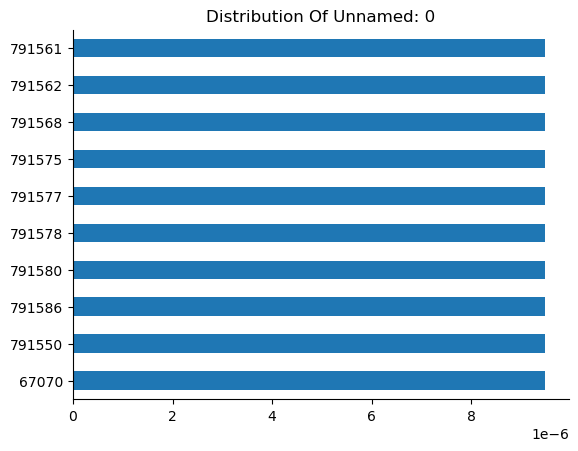

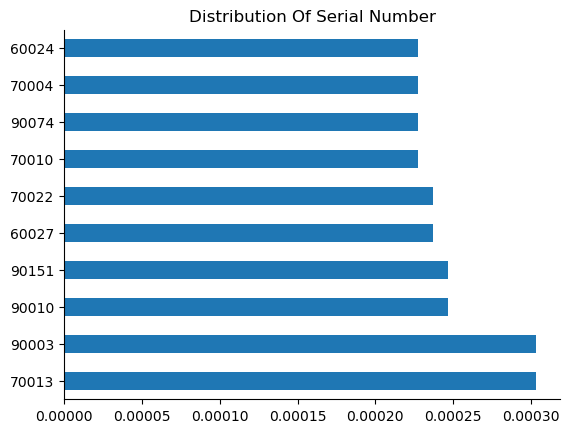

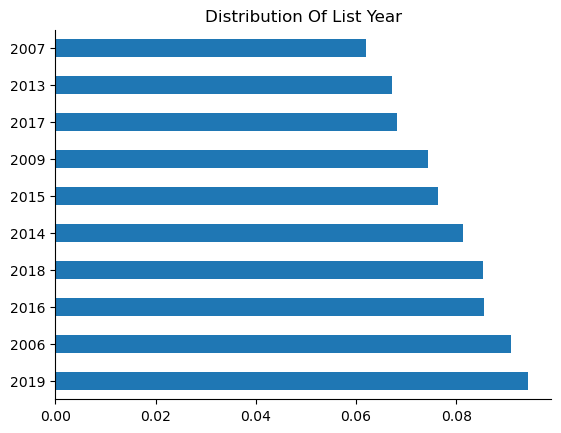

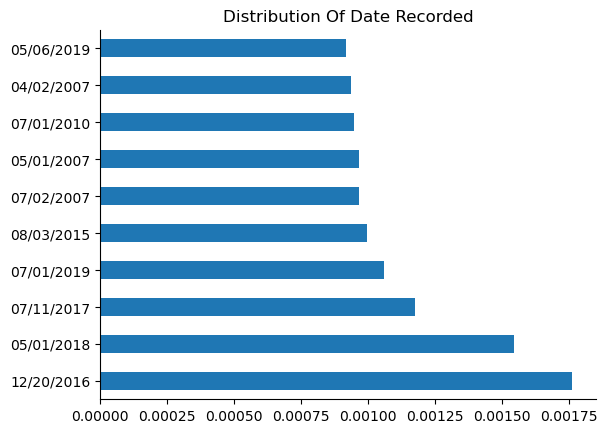

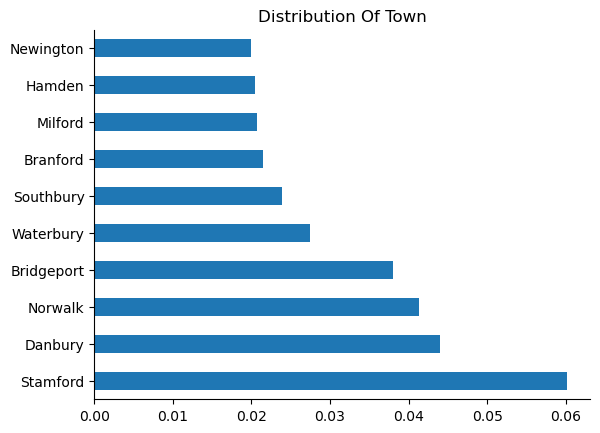

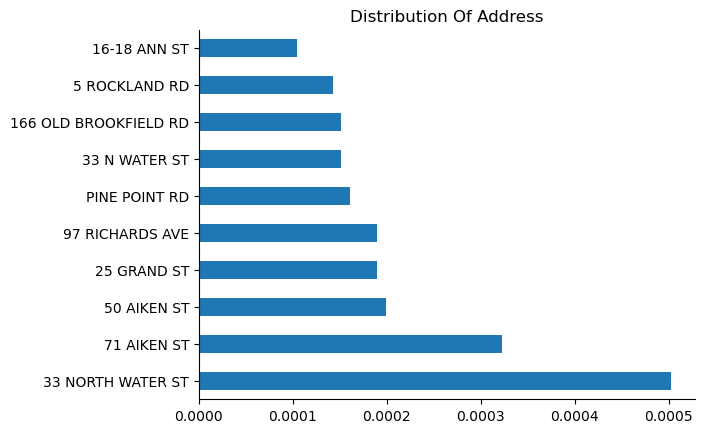

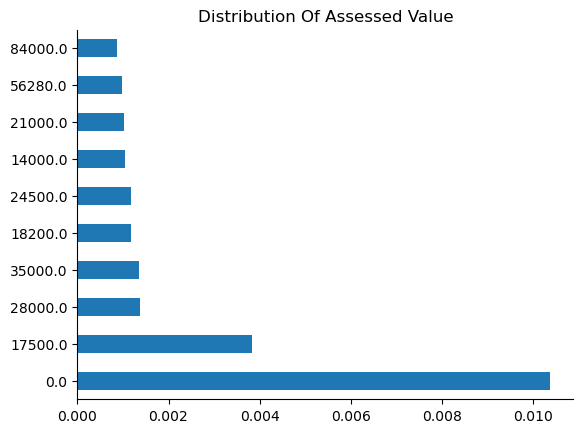

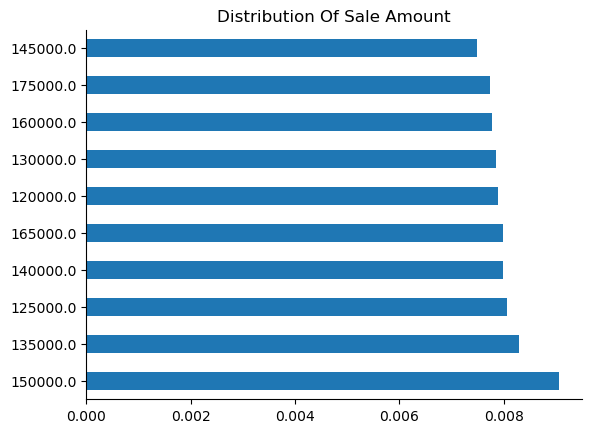

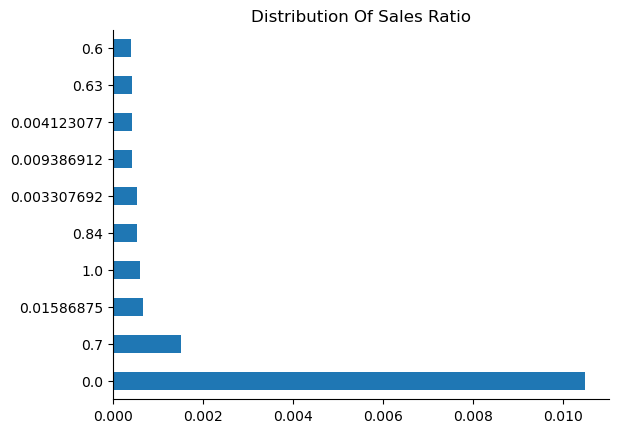

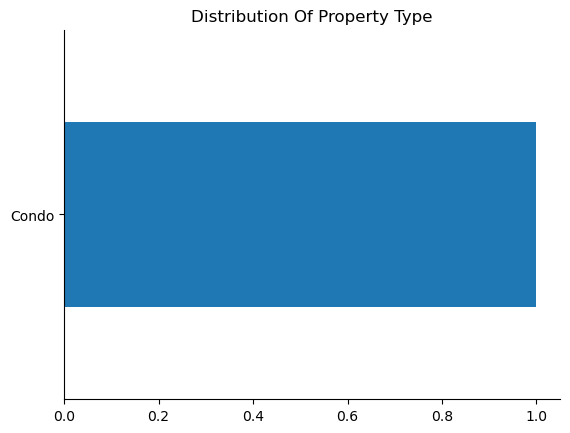

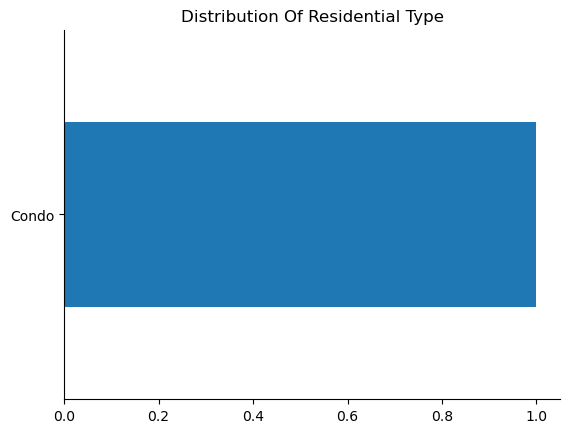

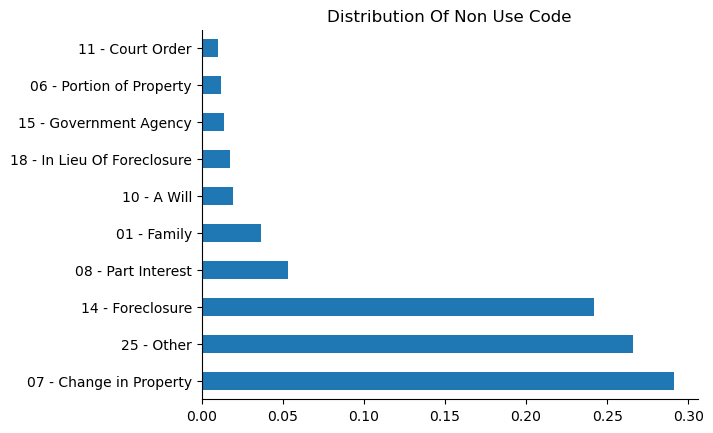

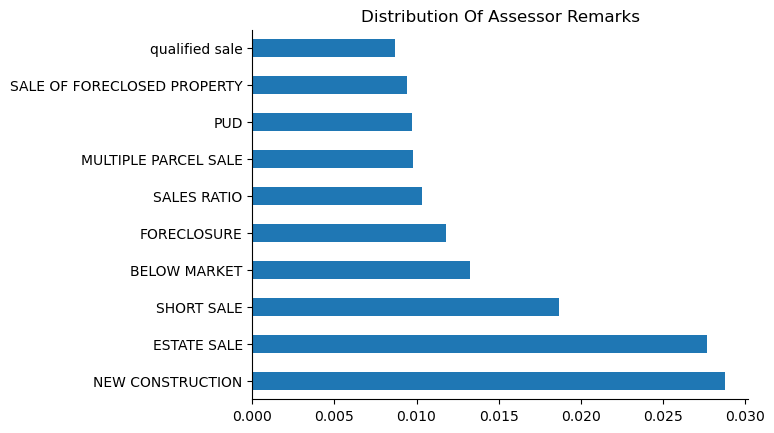

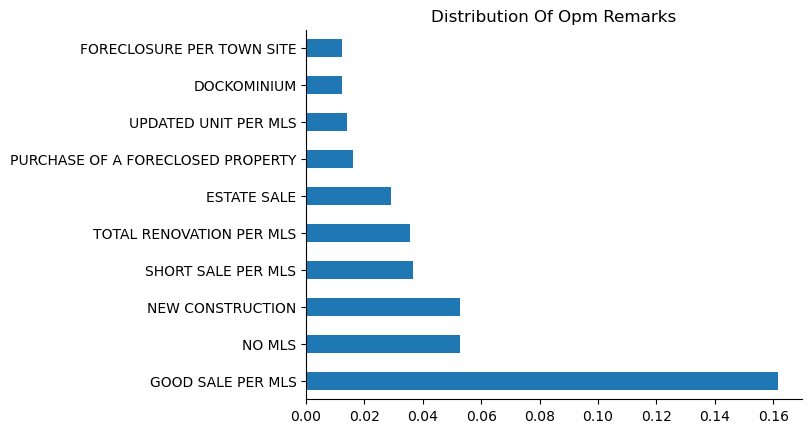

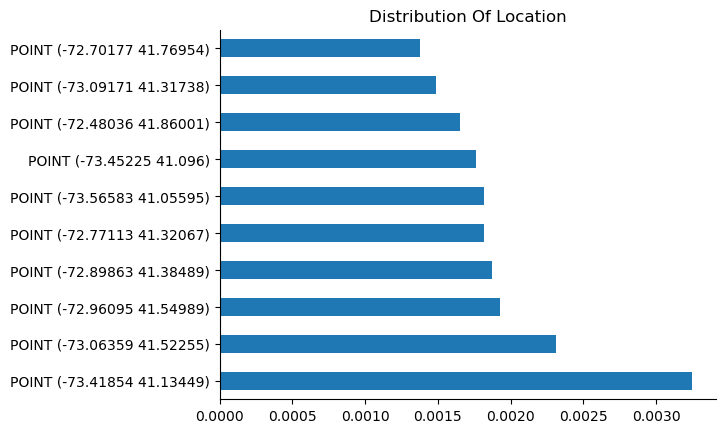

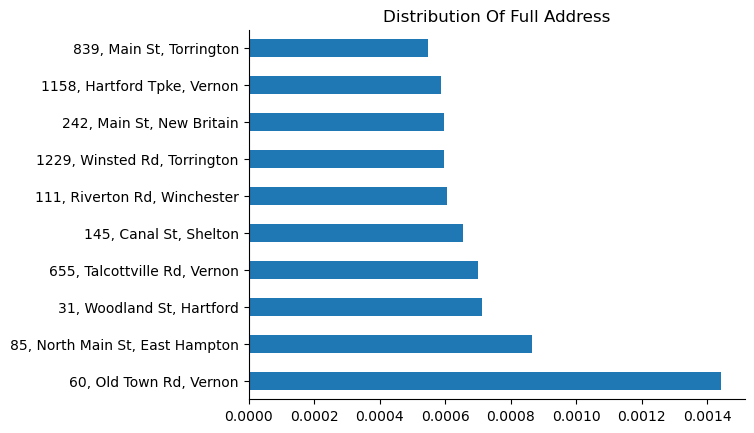

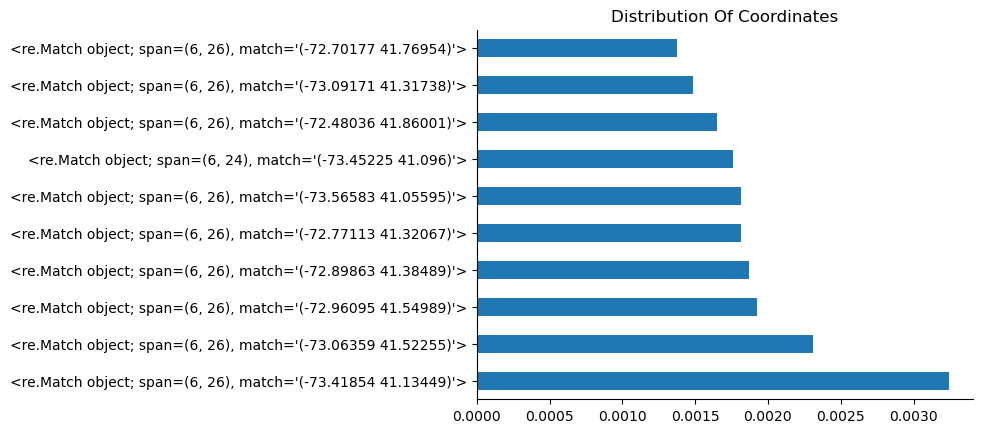

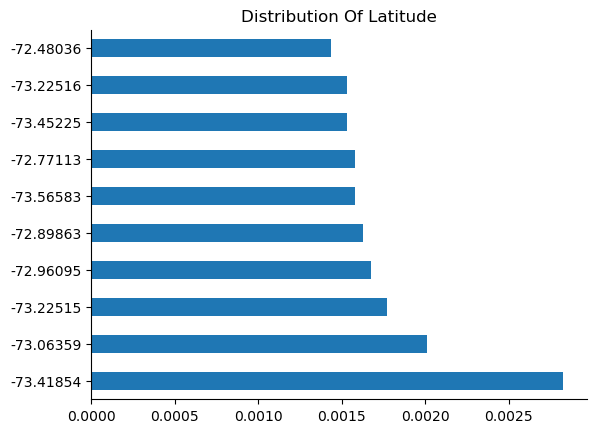

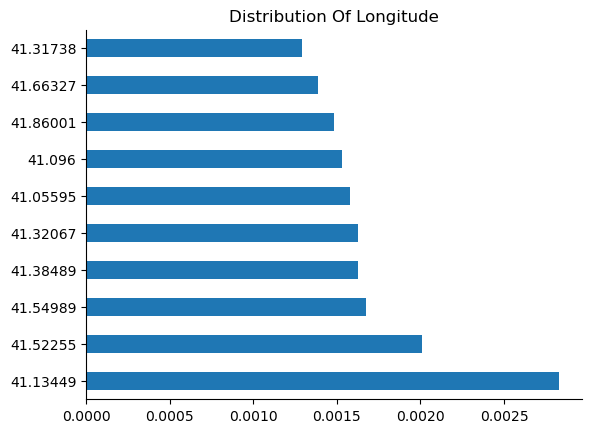

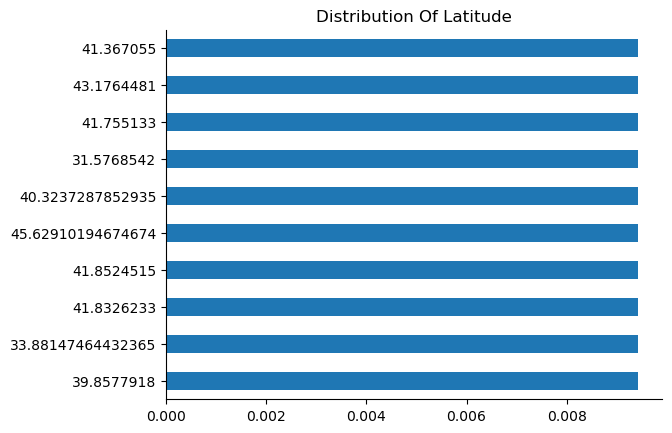

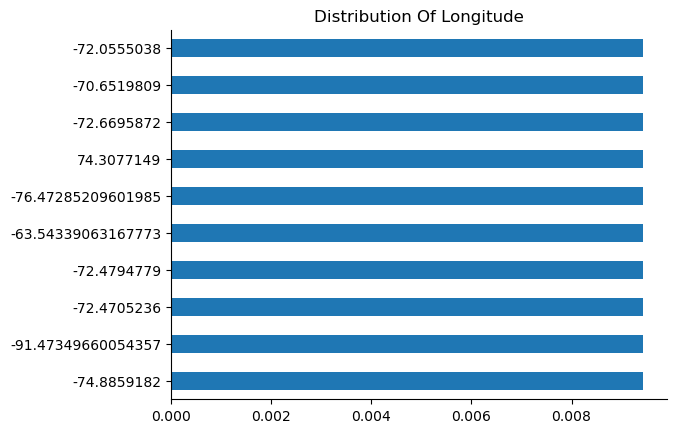

In [ ]:
for column in real_estate:
    
    # limit to top 10 counts - too many values to plot for some columnsn
    real_estate[column].value_counts(normalize=True).head(10).plot(kind="barh")
    plt.title(f"Distribution of {column}".title())
    sns.despine()
    plt.show()

In [23]:
import pandas as pd
import re
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Initialize the geocoder
geolocator = Nominatim(user_agent="bootcamp student")

real_estate = pd.DataFrame(real_estate)

max_retries = 1
last_successful_index = None  # Initialize to None

for index, row in real_estate.iterrows():
    if pd.notnull(row["latitude"]) or pd.notnull(row["longitude"]):
        # Skip to the next row if either Latitud and Longitude are already present
        continue
    address = row["Full Address"]
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(address, timeout=10)
            if location is not None:
                if location.latitude and location.longitude:
                    real_estate.at[index, "latitude"] = location.latitude
                    real_estate.at[index, "longitude"] = location.longitude
                    last_successful_index = index  # Update the index of last successful geocode
                break  # Successful geocode, break out of the loop
            else:
                break  # No more retries needed if geocoding failed
        except GeocoderTimedOut:
            retries += 1
            print("Geocoding timed out for:", address)
            print("Retrying... (Attempt", retries, "of", max_retries, ")")
    else:
        real_estate.at[index, "latitude"] = None
        real_estate.at[index, "longitude"] = None
        print("Max retries reached for:", address)

# Print the index of the last successful geocode
print("Last successful geocode index:", last_successful_index)


KeyboardInterrupt: 

In [ ]:
real_

In [ ]:
real_estate.to_csv('updated_real_estate.csv')

In [22]:
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105420 entries, 0 to 105419
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   List Year         105420 non-null  int64  
 1   Town              105420 non-null  object 
 2   Assessed Value    105420 non-null  float64
 3   Sale Amount       105420 non-null  float64
 4   Residential Type  105420 non-null  object 
 5   Non Use Code      28323 non-null   object 
 6   Assessor Remarks  23425 non-null   object 
 7   OPM remarks       1063 non-null    object 
 8   Full Address      104058 non-null  object 
 9   latitude          20888 non-null   float64
 10  longitude         20888 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 8.8+ MB


In [17]:
real_estate= real_estate.drop(columns=['Unnamed: 0', 'Serial Number', 'Date Recorded', 'Sales Ratio', 'Address', 'Location', 'coordinates'], axis=1)
real_estate.info()

KeyError: "['Serial Number', 'Date Recorded', 'Sales Ratio', 'Address', 'Location', 'coordinates'] not found in axis"

In [26]:
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105420 entries, 0 to 105419
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   List Year         105420 non-null  int64  
 1   Town              105420 non-null  object 
 2   Assessed Value    105420 non-null  float64
 3   Sale Amount       105420 non-null  float64
 4   Residential Type  105420 non-null  object 
 5   Non Use Code      28323 non-null   object 
 6   Assessor Remarks  23425 non-null   object 
 7   OPM remarks       1063 non-null    object 
 8   Full Address      104058 non-null  object 
 9   latitude          23055 non-null   float64
 10  longitude         23055 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 8.8+ MB
